In [85]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from joblib import dump
import ast  # para converter string em lista de tuplas
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


In [93]:
df_bruno = pd.read_csv("../scrub/tabelas_pessoa_pos_tratamento/bruno.csv")
df_erik = pd.read_csv("../scrub/tabelas_pessoa_pos_tratamento/erik.csv")
df_felipe = pd.read_csv("../scrub/tabelas_pessoa_pos_tratamento/felipe.csv")
df_guilherme = pd.read_csv("../scrub/tabelas_pessoa_pos_tratamento/guilherme.csv")
df_jao = pd.read_csv("../scrub/tabelas_pessoa_pos_tratamento/jao.csv")
df_jose = pd.read_csv("../scrub/tabelas_pessoa_pos_tratamento/jose.csv")
df_lo = pd.read_csv("../scrub/tabelas_pessoa_pos_tratamento/lo.csv")

In [96]:
# Lista de dataframes
dfs = [
    df_bruno, df_erik, df_felipe, df_guilherme, df_jao, df_jose, df_lo
]

nomes = [
    "bruno", "erik", "felipe", "guilherme", "jao", "jose", "lo"
]

# Normaliza coluna "piscando" para 0 e 1
for i in dfs:
    i["piscando"] = i["piscando"].map({False: 0, True: 1})


In [97]:

pontos_cols = ["pontos_olhos 1", "pontos_olhos 2", "pontos_olhos 3", "pontos_olhos 4", "pontos_olhos 5"]

def safe_eval(val):
    if isinstance(val, str):
        try:
            return ast.literal_eval(val)
        except Exception:
            return []
    elif isinstance(val, (list, tuple)):
        return val
    else:
        return []

for df in dfs:
    for col in pontos_cols:
        df[col] = df[col].apply(safe_eval)
        df[[f"{col}_x{j}" for j in range(19)]] = pd.DataFrame(
            df[col].apply(lambda pts: [p[0] for p in pts[:19]] + [None]*(19-len(pts))).tolist()
        )
        df[[f"{col}_y{j}" for j in range(19)]] = pd.DataFrame(
            df[col].apply(lambda pts: [p[1] for p in pts[:19]] + [None]*(19-len(pts))).tolist()
        )

/tmp/ipykernel_5453/1566512039.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f"{col}_x{j}" for j in range(19)]] = pd.DataFrame(
/tmp/ipykernel_5453/1566512039.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f"{col}_x{j}" for j in range(19)]] = pd.DataFrame(
/tmp/ipykernel_5453/1566512039.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

In [50]:
cm_total = np.zeros((2,2))

for idx, df_test in enumerate(dfs):
    df_train = pd.concat([df for j, df in enumerate(dfs) if j != idx], ignore_index=True)

    X_train = df_train[["ear1","ear2","ear3","ear4","ear5"]]
    y_train = df_train["piscando"]

    X_test = df_test[["ear1","ear2","ear3","ear4","ear5"]]
    y_test = df_test["piscando"]

    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    cm_total += cm


In [18]:
## SOMENTE PONTOS

feature_cols = []
for col in pontos_cols:
    feature_cols += [f"{col}_x{j}" for j in range(19)] + [f"{col}_y{j}" for j in range(19)]

cm_total = np.zeros((2,2))

# Leave-one-subject-out
for idx, df_test in enumerate(dfs):
    df_train = pd.concat([df for j, df in enumerate(dfs) if j != idx], ignore_index=True)
    
    X_train = df_train[feature_cols]
    y_train = df_train["piscando"]
    
    X_test = df_test[feature_cols]
    y_test = df_test["piscando"]
    
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    cm_total += cm


In [ ]:
## PROCURANDO MELHOR LIMIAR GERAL

from sklearn.metrics import confusion_matrix, accuracy_score

# juntar todos os dfs
dfs_combined = pd.concat(dfs, ignore_index=True)

X = dfs_combined[["ear1","ear2","ear3","ear4","ear5"]]
y = dfs_combined["piscando"].astype(int)

# valores médios linha a linha

def evaluate_threshold(threshold):
    y_pred = (X.mean(axis=1) > threshold).astype(float)
    acc = accuracy_score(y, y_pred)
    return acc, confusion_matrix(y, y_pred)

# intervalo inicial para os limiares
low, high = 1, 100
best_acc = -1
best_thr = None
best_cm = None

print(f"Intervalo inicial: [{low:.4f}, {high:.4f}]")

for _ in range(50):  # iterações
    mid = (low + high) / 2  # meio do intervalo
    
    acc, cm = evaluate_threshold(mid)
    
    if acc > best_acc:
        best_acc, best_thr, best_cm = acc, mid, cm
    
    # Ajusta o intervalo
    if np.sum(cm[0]) > np.sum(cm[1]):  # mais negativos
        high = mid  # busca no intervalo inferior
    else:
        low = mid  # busca no intervalo superior    

print(f"Melhor limiar: {best_thr:.4f}")
print(f"Acurácia: {best_acc:.4f}")
print("Matriz de confusão:\n", best_cm)


Intervalo inicial: [1.0000, 100.0000]
Melhor limiar: 7.1875
Acurácia: 0.9368
Matriz de confusão:
 [[10818   659]
 [  515  6578]]


In [95]:
## PROCURANDO MELHOR LIMIAR POR PESSOA
def evaluate_threshold(threshold, y, X):
    y_pred = (X.mean(axis=1) > threshold).astype(float)
    acc = accuracy_score(y, y_pred)
    return acc, confusion_matrix(y, y_pred)

from sklearn.metrics import confusion_matrix, accuracy_score

for idx, df_test in enumerate(dfs):

    X = df_test[["ear1","ear2","ear3","ear4","ear5"]]
    y = df_test["piscando"].astype(int)

    # valores médios linha a linha

    # intervalo inicial para os limiares
    low, high = X.mean(axis=1).min(), X.mean(axis=1).max()
    best_acc = -1
    best_thr = None
    best_cm = None


    for _ in range(100):  # iterações
        mid = (low + high) / 2  # meio do intervalo
        
        acc, cm = evaluate_threshold(mid, y, X)
        
        if acc > best_acc:
            best_acc, best_thr, best_cm = acc, mid, cm
        
        # Ajusta o intervalo
        if np.sum(cm[0]) > np.sum(cm[1]):  # mais negativos
            high = mid  # busca no intervalo inferior
        else:
            low = mid  # busca no intervalo superior    

    print(f"Melhor limiar para {nomes[idx]}: {best_thr:.4f}")
    print(f"Acurácia: {best_acc:.4f}")


Melhor limiar para bruno: 5.5057
Acurácia: 0.9181
Melhor limiar para erik: 18.1461
Acurácia: 0.9800
Melhor limiar para felipe: 5.5057
Acurácia: 0.9341
Melhor limiar para guilherme: 5.5057
Acurácia: 0.9457
Melhor limiar para jao: 5.3049
Acurácia: 0.9310
Melhor limiar para jose: 5.3049
Acurácia: 0.9241
Melhor limiar para lo: 5.3049
Acurácia: 0.9238


In [76]:
cm_total = np.zeros((2,2))

dfs_combined = pd.concat(dfs, ignore_index=True)

X = dfs_combined[["ear1","ear2","ear3","ear4","ear5"]]
y = dfs_combined["piscando"]

y_pred = (X.mean(axis=1) > 7.5).astype(float)

print(accuracy_score(y, y_pred))

cm = confusion_matrix(y, y_pred)
cm_total += cm


0.935271943995692


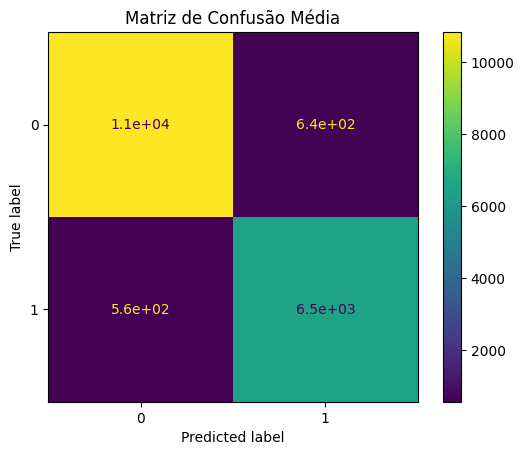

In [71]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_total, display_labels=[0,1])
disp.plot()
plt.title("Matriz de Confusão Média")
plt.show()

In [72]:
def calculate_metrics_from_cm(cm, precision_digits=3):

    TN, FP, FN, TP = cm.ravel()

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    metrics = {
        "Acurácia": round(accuracy, precision_digits),
        "Precisão": round(precision, precision_digits),
        "Revocação": round(recall, precision_digits),
        "F1-Score": round(f1_score, precision_digits),
    }
    
    return metrics

print(calculate_metrics_from_cm(cm_total))

{'Acurácia': np.float64(0.935), 'Precisão': np.float64(0.911), 'Revocação': np.float64(0.921), 'F1-Score': np.float64(0.916)}
